<a href="https://colab.research.google.com/github/TMUITLab/EAFR/blob/master/EA15fordraw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd '/content'
!git clone https://github.com/1049451037/GCN-Align
!git clone https://github.com/MaoXinn/RREA

/content
Cloning into 'GCN-Align'...
remote: Enumerating objects: 53, done.
remote: Total 53 (delta 0), reused 0 (delta 0), pack-reused 53
Unpacking objects: 100% (53/53), done.
Cloning into 'RREA'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 32 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [4]:
import warnings
warnings.filterwarnings('ignore')

from importlib.machinery import SourceFileLoader
from google.colab import files

layer = SourceFileLoader("layer", "/content/RREA/CIKM/layer.py").load_module()
utils = SourceFileLoader("utils", "/content/RREA/CIKM/utils.py").load_module()
CSLS = SourceFileLoader("CSLS", "/content/RREA/CIKM/CSLS.py").load_module()
import tensorflow as tf
import os
import time
import random
import keras
import pickle
from scipy.sparse import hstack
import math
from tqdm import *
import numpy as np
from utils import *
from CSLS import *
import tensorflow as tf
import keras.backend as K
from keras.layers import *
from layer import NR_GraphAttention

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
!unzip '/content/GCN-Align/data/rrk.zip' -d '/content/GCN-Align/data/'

In [6]:
lang = 'rrk5-0-5'
main_radj,train_pair,dev_pair,adj_matrix,r_index,r_val,adj_features,rel_features,nadj,char_size = load_data('/content/GCN-Align/data/%s/'%lang,train_ratio=0.30)
train_pair_main=train_pair
adj_matrix = np.stack(adj_matrix.nonzero(),axis = 1)
main_rel_matrix,rel_val = np.stack(rel_features.nonzero(),axis = 1),rel_features.data
ent_matrix,ent_val = np.stack(adj_features.nonzero(),axis = 1),adj_features.data

33793 2


In [7]:
rel_size = rel_features.shape[1] 


# pair_dic = dict()
# pairs = np.concatenate((dev_pair , train_pair),axis=0)
# for i in range(len(pairs)):
#     pair_dic[pairs[i][0]] = pairs[i][1]


main_rel_matrix1 = main_rel_matrix.copy()
for i in range(len(main_rel_matrix1)):
  main_rel_matrix1[i,1] = (main_rel_matrix1[i,1] + rel_size//2) % rel_size

main_radj1 = np.array(sorted(main_radj.copy(),key=lambda x: x[1]*10e10+x[0]*10e5))
for i in range(len(main_radj1)):
  _x,_y = main_radj1[i,0],main_radj1[i,1]
  main_radj1[i,0] = _y
  main_radj1[i,1] = _x
  main_radj1[i,2] = main_radj1[i,2] #( + rel_size//2) % rel_size
single_triple_set = set()
degree = np.zeros([adj_features.shape[0],3])
for triple in main_radj:
    single_triple_set.add((triple[0],triple[1]))
    if triple[2] < rel_size //2:
        degree[triple[0],0] += 1
        degree[triple[1],0] += 1
        degree[triple[0],2] += 1
        degree[triple[1],1] += 1

dev_pair_degrees = np.zeros([2,len(dev_pair),3])
for i in range(len(dev_pair)):
    dev_pair_degrees[0,i,0] = degree[dev_pair[i][0],0]
    dev_pair_degrees[0,i,1] = degree[dev_pair[i][0],1]
    dev_pair_degrees[0,i,2] = degree[dev_pair[i][0],2]
    dev_pair_degrees[1,i,0] = degree[dev_pair[i][1],0]
    dev_pair_degrees[1,i,1] = degree[dev_pair[i][1],1]
    dev_pair_degrees[1,i,2] = degree[dev_pair[i][1],2]

train_pair_degrees = np.zeros([2,len(train_pair),3])
for i in range(len(train_pair)):
    train_pair_degrees[0,i,0] = degree[train_pair[i][0],0]
    train_pair_degrees[0,i,1] = degree[train_pair[i][0],1]
    train_pair_degrees[0,i,2] = degree[train_pair[i][0],2]
    train_pair_degrees[1,i,0] = degree[train_pair[i][1],0]
    train_pair_degrees[1,i,1] = degree[train_pair[i][1],1]
    train_pair_degrees[1,i,2] = degree[train_pair[i][1],2]

ent_size = adj_features.shape[0]
depth = 3
deg = np.zeros([ent_size])
deg_in = np.zeros([ent_size])
deg_out = np.zeros([ent_size])
bdeg = np.zeros([ent_size])


single_graph = dict()
for h,t,r in main_radj:
    deg[h] += 1
    deg[t] += 1
    deg_in[t] += 1
    deg_out[h] += 1
    if(h not in single_graph):
        single_graph[h] = [t]
    else:
        single_graph[h] += [t]
for i in range(ent_size):
    bdeg[i] = math.floor(math.log(i+1))

bin = int(max(bdeg))
rec_deg = np.zeros([ent_size,bin*depth])
for h in single_graph:
    set_len = len(single_graph[h])
    for i in single_graph[h]:
        rec_deg[h,int(bdeg[i])] += 1/set_len
for d in range(1,depth):
    
    for h in single_graph:
        set_len = len(single_graph[h])
        for i in single_graph[h]:
            rec_deg[h,d*bin:(d+1)*bin] += (rec_deg[i,(d-1)*bin:(d)*bin])/set_len


In [8]:
entity1, rel1, triples1 = load_triples('/content/GCN-Align/data/%s/'%lang + 'triples_1')
num_entity_1 = len(entity1)
num_rel_1 = len(rel1)

entity2, rel2, triples2 = load_triples('/content/GCN-Align/data/%s/'%lang + 'triples_2')
num_entity_2 = len(entity2)
num_rel_2 = len(rel2)

In [9]:
layer = SourceFileLoader("layer", "/content/RREA/CIKM/layer.py").load_module()

from layer import NR_GraphAttention
tf.keras.backend.clear_session()
radj = main_radj
radj1 = main_radj1
rel_matrix = main_rel_matrix
rel_matrix1 = main_rel_matrix1
node_size = adj_features.shape[0]
rel_size = rel_features.shape[1]
triple_size = len(adj_matrix)
batch_size = node_size
datas = []
# e stand for entity ,r stand for relation , E stand for encoder(e), c stand for character embedding , R stand for encoder(r)
run_name = 'QeER'

def getMax(d):
    l = list(d.keys())
    random.shuffle(l)
    m = 0 
    max_key = -1;
    num_max = 0
    for k in l : 
        if d[k] > m :
            max_key = k
            m = d[k]
            num_max = 1
        elif d[k] == m:
            num_max += 1
    if num_max > 1:
        max_key = -1
    return max_key

def get_match_relations(tpair , threshold = 50):
    rmap_predict = dict()
    temp_train_pair_dic = dict()
    for i in range(len(tpair)):
        temp_train_pair_dic[tpair[i][0]] = tpair[i][1]
    triple_dic = dict()
    for h,t,r in radj:
        if r < (rel_size //2) :
            if (h,t) in triple_dic:
                triple_dic[(h,t)] += [r]
            else:
                triple_dic[(h,t)] = [r]
    for h,t,r in radj:
        if h in temp_train_pair_dic and t in temp_train_pair_dic and h != t and r < rel_size //2:
            z = np.zeros([rel_size])
            if (temp_train_pair_dic[h],temp_train_pair_dic[t]) in triple_dic:
                z[triple_dic[(temp_train_pair_dic[h],temp_train_pair_dic[t])]] = 1
                if r in rmap_predict :
                    rmap_predict[r] += z
                else:
                    rmap_predict[r] = z
    i = 0
    matched_dic = dict()
    for key in rmap_predict:
        v = np.max(rmap_predict[key])
        i += 1
        if(v>threshold):
            a = np.argmax(rmap_predict[key]) % (rel_size//2)
            matched_dic[key] = a
    #print(matched_dic);
    return matched_dic

def complete_graph(tpair,threshold=2,num = 1):
    
    new_train_pair = tpair.copy()
    for i in range(num):
        train_pair_dic1 = dict()
        for a,b in new_train_pair : 
            train_pair_dic1[a] = b
        selected_rmap = get_match_relations(new_train_pair,threshold)
        print('number of matched relation is : ' ,len(selected_rmap) )
        si = dict()
        so = dict()

        for h,t,r in radj:
          if (t,r) not in si:
            si[(t,r)] = [h]
          else:
            si[(t,r)] += [h]

          if (h,r) not in so:
            so[(h,r)] = [t]
          else:
            so[(h,r)] += [t]

        lmap = dict()
        rmap = dict()
        tmap = dict()
        for h,t,r in radj:
            if h in train_pair_dic1 and r in selected_rmap :
                if (train_pair_dic1[h],selected_rmap[r]) in so:
                    for t1 in so[(train_pair_dic1[h],selected_rmap[r])]:
                        if t not in lmap:
                            lmap[t] = dict()
                        if t1 not in lmap[t]:
                            lmap[t][t1] = 1
                        else:
                            lmap[t][t1] += 1

            if t in train_pair_dic1 and r in selected_rmap  :
                if (train_pair_dic1[t],selected_rmap[r]) in si:
                    for h1 in si[(train_pair_dic1[t],selected_rmap[r])]:
                        if h not in rmap:
                            rmap[h] = dict()
                        if h1 not in rmap[h]:
                            rmap[h][h1] = 1
                        else:
                            rmap[h][h1] += 1
        for t in lmap:
            if t not in tmap:
                tmap[t] = dict()
            for key in lmap[t]:
                if key not in tmap[t]:
                    tmap[t][key] = lmap[t][key]
                else:
                    tmap[t][key] += lmap[t][key]

        for t in rmap:
            if t not in tmap:
                tmap[t] = dict()
            for key in rmap[t]:
                if key not in tmap[t]:
                    tmap[t][key] = rmap[t][key]
                else:
                    tmap[t][key] += rmap[t][key]
        l = []
        for a in tmap:
            if a not in train_pair_dic :
                train_pair_dic1[a] = getMax(tmap[a])
                l.append([a,train_pair_dic1[a] ])
             

        # for a,b in pairs:
        #     if a not in train_pair_dic :
        #       if a in tmap:
        #           train_pair_dic1[a] = getMax(tmap[a])
        #           l.append([a,train_pair_dic1[a] ])
        #       elif a in lmap:
        #           train_pair_dic1[a] = getMax(lmap[a])
        #           l.append([a,train_pair_dic1[a] ])
        #       elif a in rmap:
        #           train_pair_dic1[a] = getMax(rmap[a])
        #           l.append([a,train_pair_dic1[a]])

        s = 0
        if (len(l) == 0):
            return train_pair_dic1;
        new_train_pair = np.concatenate([new_train_pair,np.array(l)],axis=0)
        # for t in train_pair_dic1:
        #     if t not in train_pair_dic and pair_dic[t] == train_pair_dic1[t]:
        #         s += 1
        # print(s/(len(pair_dic)-len(train_pair_dic)),len(train_pair_dic1)-len(train_pair_dic))
    return train_pair_dic1

def replce_matched_relations(threshold = 50):
    matched_dic = get_match_relations(threshold)
    for i in range(len(radj)) :
        h = radj[i,0]
        t = radj[i,1]
        r = radj[i,2]
        if r in matched_dic :
            radj[i,2] = matched_dic[r]
        elif (r - rel_size//2) in matched_dic:
            radj[i,2] = matched_dic[(r - rel_size//2)]   + (rel_size//2)

    for i in range(len(rel_matrix)) :
        h = rel_matrix[i,0]
        r = rel_matrix[i,1]
        if r in matched_dic :
            rel_matrix[i,1] = matched_dic[r]
        elif (r - rel_size//2) in matched_dic:
            rel_matrix[i,1] = matched_dic[(r - rel_size//2)]   + (rel_size//2)


class TokenEmbedding(keras.layers.Embedding):
    """Embedding layer with weights returned."""

    def compute_output_shape(self, input_shape):
        return self.input_dim, self.output_dim

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, inputs):
        return self.embeddings
    
def get_embedding(add_rel_feature = False,threshold = 50,depth = 2):
    inputs = [adj_matrix,r_index,r_val,rel_matrix,rel_matrix1,ent_matrix,radj,radj1,nadj]
    inputs = [np.expand_dims(item,axis=0) for item in inputs]
    if add_rel_feature == False:
        return get_emb.predict_on_batch(inputs)
    else:
        selected_rmap = get_match_relations(threshold)
        rselected_rmap = dict()
        i = 0
        for key in selected_rmap:
            rselected_rmap[key] = i
            rselected_rmap[selected_rmap[key]] = i
            i += 1
        f = np.zeros([node_size,len(selected_rmap)*depth])
        for h,t,r in radj:
            if r in rselected_rmap:
                f[h,rselected_rmap[r]] += 1./degree[h,2]
            
        for i in range(depth-1):
            for h,t,r in radj:
                f[h,(i+1)*depth:(i+2)*depth] += 1./degree[h,2] * f[t,(i)*depth:(i+1)*depth]

        f1 = get_emb.predict_on_batch(inputs)
        f1 = f1 / np.linalg.norm(f1,axis=-1,keepdims=True)
        f = f / np.linalg.norm(f,axis=-1,keepdims=True)
        f2 = np.concatenate([f,f1],axis=1)
        return f

def test(wrank = None):
    vec = get_embedding()
    return  get_hits(vec,dev_pair,wrank=wrank)

def CSLS_test(thread_number = 16, csls=10,accurate = True):
    vec = get_embedding()
    #vec =get_embedding(True,threshold = 2,depth = 1)
    trest_set_1 = [e1 for e1, e2 in dev_pair]
    trest_set_2 = [e2 for e1, e2 in dev_pair]
    Lvec = np.array([vec[e1] for e1, e2 in dev_pair])
    Rvec = np.array([vec[e2] for e1, e2 in dev_pair])

    Lvec = Lvec / np.linalg.norm(Lvec,axis=-1,keepdims=True)
    Rvec = Rvec / np.linalg.norm(Rvec,axis=-1,keepdims=True)

    # Lvec1 = np.array([rec_deg[e1] for e1, e2 in dev_pair])
    # Rvec1 = np.array([rec_deg[e2] for e1, e2 in dev_pair])

    # Lvec1 = 0.5 * Lvec1 / np.linalg.norm(Lvec1,axis=-1,keepdims=True)
    # Rvec1 = 0.5 * Rvec1 / np.linalg.norm(Rvec1,axis=-1,keepdims=True)

    # Lvec = np.concatenate([Lvec,Lvec1],axis=-1)
    # Rvec = np.concatenate([Rvec,Rvec1],axis=-1)

    # Lvec = Lvec / np.linalg.norm(Lvec,axis=-1,keepdims=True)
    # Rvec = Rvec / np.linalg.norm(Rvec,axis=-1,keepdims=True)

    lprec,ldata,_ = eval_alignment_by_sim_mat(Lvec, Rvec, [1, 5, 10], thread_number, csls=csls, accurate=accurate)
    results = np.zeros([len(dev_pair)])

    for i in range(len(dev_pair)):
        if((i,i) in lprec):
            results[i] = 1

    datas.append((results,ldata))
    save_datas()
    return None

def save_datas():
    with open('/content/RREA/'+lang+"_"+run_name+'.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([train_pair_degrees,dev_pair_degrees,datas], f)

def load_datas():
    with open('/content/RREA/'+lang+"_"+run_name+'.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
        mydata =pickle.load(f)
    return mydata;

def get_train_set(batch_size = batch_size):
    negative_ratio =  batch_size // len(train_pair) + 1
    train_set = np.reshape(np.repeat(np.expand_dims(train_pair,axis=0),axis=0,repeats=negative_ratio),newshape=(-1,2))
    np.random.shuffle(train_set); train_set = train_set[:batch_size]
    train_set = np.concatenate([train_set,np.random.randint(0,node_size,[train_set.shape[0],4])],axis = -1)
    return train_set

def get_train_set1(batch_size = batch_size):
    train_set = train_pair
    np.random.shuffle(train_set);
    train_set = np.concatenate([train_set,np.random.randint(0,node_size,train_set.shape)],axis = -1)
    return train_set

def get_trgat(node_size,rel_size,node_hidden,rel_hidden,triple_size,n_attn_heads = 2,dropout_rate = 0,gamma = 3,lr = 0.005,depth = 2):
    adj_input = Input(shape=(None,2))
    index_input = Input(shape=(None,2),dtype='int64')
    val_input = Input(shape = (None,))
    rel_adj = Input(shape=(None,2))
    rel_adj1 = Input(shape=(None,2))
    ent_adj = Input(shape=(None,2))
    radj = Input(shape=(None,3),dtype='int64')
    radj1 = Input(shape=(None,3),dtype='int64')
    nadj = Input(shape=(None,3))
    
    # ent_emb = TokenEmbedding(node_size,node_hidden,embeddings_initializer="LecunNormal",trainable = True)(val_input) 
    # rel_emb = TokenEmbedding(rel_size,node_hidden,embeddings_initializer="LecunNormal",trainable = True)(val_input)
    # ch_emb = TokenEmbedding(char_size,node_hidden,embeddings_initializer="LecunNormal",trainable = True)(val_input)

    ent_emb = TokenEmbedding(node_size,node_hidden,trainable = True)(val_input) 
    rel_emb = TokenEmbedding(rel_size,node_hidden,trainable = True)(val_input)
    ch_emb = TokenEmbedding(char_size,node_hidden,trainable = True)(val_input)


    # E = TokenEmbedding(node_hidden,node_hidden,trainable = True)(val_input)
    # R = TokenEmbedding(node_hidden,node_hidden,trainable = True)(val_input)
    def ch_avg(tensor,size):
        n_adj = tf.squeeze(tensor[0],axis = 0)
        adj = K.cast(n_adj[:,0:2],dtype = "int64")   
        adj = tf.SparseTensor(indices=adj, values=tf.ones_like(n_adj[:,2],dtype = 'float32') , dense_shape=(node_size,size)) 
        adj = tf.compat.v1.sparse_softmax(adj) 
        l_adj = tf.compat.v1.sparse_tensor_dense_matmul(adj,tensor[1])
        return l_adj

    def avg(tensor,size):
        adj = K.cast(K.squeeze(tensor[0],axis = 0),dtype = "int64")   
        adj = tf.SparseTensor(indices=adj, values=tf.ones_like(adj[:,0],dtype = 'float32'), dense_shape=(node_size,size)) 
        adj = tf.compat.v1.sparse_softmax(adj) 
        l_adj = tf.compat.v1.sparse_tensor_dense_matmul(adj,tensor[1])
        return l_adj

    name_feature = Lambda(ch_avg,arguments={'size':char_size})([nadj,ch_emb])
    # rel_feature1 = Lambda(avg,arguments={'size':rel_size//2})([rel_adj,rel_emb])
    # rel_feature2 = Lambda(avg,arguments={'size':rel_size//2})([rel_adj1,rel_emb])
    rel_feature = Lambda(avg,arguments={'size':rel_size})([rel_adj,rel_emb])
    # rel_feature1= Lambda(avg,arguments={'size':node_size})([rel_adj,rel_feature])
    # rel_feature = 0.8 * rel_feature + 0.2 * rel_feature1

    ent_feature = Lambda(avg,arguments={'size':node_size})([ent_adj,ent_emb])
    ent_feature1 = Lambda(avg,arguments={'size':node_size})([ent_adj,ent_feature])
    ent_feature = 0.8 * ent_feature + 0.2 * ent_feature1
    # rel_emb = K.concatenate([rel_emb1,rel_emb2])
    #rel_feature = K.concatenate([rel_feature1,rel_feature2])

    encoder = NR_GraphAttention(node_size,activation="relu",
                                       rel_size = rel_size,
                                       depth =2,
                                       attn_heads=n_attn_heads,
                                       triple_size = triple_size,
                                       attn_heads_reduction='average',   
                                       dropout_rate=dropout_rate)
    encoder1 = NR_GraphAttention(node_size,activation="relu",
                                    rel_size = rel_size,
                                    depth = 2,
                                    attn_heads=n_attn_heads,
                                    triple_size = triple_size,
                                    attn_heads_reduction='average',   
                                    dropout_rate=dropout_rate)
    encoder2 = NR_GraphAttention(node_size,activation="relu",
                                       rel_size = rel_size,
                                       depth = 2,
                                       attn_heads=n_attn_heads,
                                       triple_size = triple_size,
                                       attn_heads_reduction='average',   
                                       dropout_rate=dropout_rate)
    opt1 = [rel_emb,adj_input,index_input,val_input,radj,radj1]
    opt2 = [rel_emb,adj_input,index_input,val_input,radj1]
    elements = []
    coefs = []
    for f_name in run_name:
        if f_name == 'e':
            elements += [ent_emb]
            coefs += [0.2]
        elif f_name == 'E':
            elements += encoder1([ent_feature]+opt1) 
            coefs += [0.8,0.8,0.8]
        elif f_name == 'R':
            elements += encoder1([rel_feature]+opt1) #+ encoder([rel_feature1]+opt2)
            coefs +=  [0.8,0.8,0.8]
        elif f_name == 'q':
            elements += [rel_feature1]
            coefs +=  [-0.5]
        elif f_name == 'C':
            elements += encoder2([name_feature]+opt1)
            coefs +=  [0.8,0.8,0.8]
        elif f_name == 'c':
            elements += [name_feature]
            coefs += [1.]

    #elements = [ent_emb] +   encoder([rel_feature]+opt1)+encoder([ent_feature]+opt1)
    #elements = [0.3 * ent_emb[:,:node_hidden//2]]+ el[0:3]+el[6:9]+[0.2 * ent_emb[:,node_hidden//2:]] + el[3:6]+el[9:12]
    num_el = elements.__len__()
    alpha =  tf.Variable([0.2], trainable=False)
    weight =  tf.Variable(coefs, trainable=False)
    #weight = (num_el-1)* tf.math.softmax(weight)
    #weight =  tf.Variable(1 * [-0.2,1.0] + (num_el-2) * [.8], trainable=False)
    print(weight)
    #elements = [alpha * elements[0]] + [elements[_i+1]*(1-alpha) for _i in range(len(elements)-1) ]
    elements = [elements[_i]*weight[_i] for _i in range(len(elements)) ]
    out_feature = Concatenate(-1)(elements)
    out_feature = Dropout(dropout_rate)(out_feature)
    
    alignment_input = Input(shape=(None,6),dtype = "int64") 
    #find = Lambda(lambda x:K.gather(reference=x[0],indices=K.cast(K.squeeze(x[1],axis=0), 'int32')))([out_feature,alignment_input])

    I = K.cast(K.squeeze(alignment_input,axis=0),dtype = "int64")
   
    A = K.sum(K.abs(K.gather(out_feature,I[:,0])-K.gather(out_feature,I[:,1])),axis=-1,keepdims=True)
    loss = 0.1 * ( K.relu(1 - K.sum(K.abs(K.gather(out_feature,I[:,0])))) +K.relu(1 - K.sum(K.abs(K.gather(out_feature,I[:,1])))))
    for i in range(2):
        B = K.sum(K.abs(K.gather(out_feature,I[:,0])-K.gather(out_feature,I[:,2+i])),axis=-1,keepdims=True)
        C = K.sum(K.abs(K.gather(out_feature,I[:,1])-K.gather(out_feature,I[:,2+i])),axis=-1,keepdims=True)
        loss += K.relu(gamma +A -B) + K.relu(gamma +A -C)
        loss += 0.1 * ( K.relu(1 - K.sum(K.abs(K.gather(out_feature,I[:,2+i])))))
    loss =  tf.compat.v1.reduce_sum(loss,keep_dims=True) / (batch_size)    
   
    inputs = [adj_input,index_input,val_input,rel_adj,rel_adj1,ent_adj,radj,radj1,nadj]
    train_model = keras.Model(inputs = inputs + [alignment_input],outputs = loss)
    
    train_model.compile(loss=lambda y_true,y_pred: y_pred,optimizer=tf.keras.optimizers.RMSprop(lr=lr))
    
    feature_model = keras.Model(inputs = inputs,outputs = out_feature)
    return train_model,feature_model

In [10]:
run_name = 'eER'
model,get_emb = get_trgat(dropout_rate=0.3,node_size=node_size,rel_size=rel_size,n_attn_heads = 1,depth=2,gamma =3,node_hidden=100,rel_hidden = 100,triple_size = triple_size)
#model.summary(); 
initial_weights = model.get_weights()

<tf.Variable 'Variable:0' shape=(7,) dtype=float32, numpy=array([0.2, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8], dtype=float32)>


In [ ]:
train_pair = train_pair_main

train_pair_dic = dict()
for i in range(len(train_pair)):
    train_pair_dic[train_pair[i][0]] = train_pair[i][1]
    
radj = main_radj
radj1 = main_radj1
rel_matrix = main_rel_matrix
rel_matrix1 = main_rel_matrix1  
tf.keras.backend.clear_session()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True  
sess = tf.compat.v1.Session(config=config) 

rest_set_1 = [e1 for e1, e2 in dev_pair]
rest_set_2 = [e2 for e1, e2 in dev_pair]
np.random.shuffle(rest_set_1)
np.random.shuffle(rest_set_2)
print ('entity alignment started for dataset' , lang, run_name)
epoch = 200
hb = True
for turn in range(1,30):
    print("iteration %d start."%turn)
    for i in trange(epoch):
        cur_epoch = i
        train_set = get_train_set()
        
        inputs = [adj_matrix,r_index,r_val,rel_matrix,rel_matrix1,ent_matrix,radj,radj1,nadj,train_set]
        inputs = [np.expand_dims(item,axis=0) for item in inputs]
        model.train_on_batch(inputs,np.zeros((1,1)))
        #CSLS_test()
        if i%100 == 99 and i+1 != epoch:
            
            CSLS_test()     

    # if turn == 0:
    #     epoch = 100
    #     CSLS_test()
    #     break;
    CSLS_test()       
    new_pair1 = []
    new_pair = []
    if (len(rest_set_1) < 10 or len(rest_set_2) < 10):
        continue
    #vec = get_embedding()
    vec = get_embedding()
    Lvec = np.array([vec[e] for e in rest_set_1])
    Rvec = np.array([vec[e] for e in rest_set_2])
    Lvec = Lvec / np.linalg.norm(Lvec,axis=-1,keepdims=True)
    Rvec = Rvec / np.linalg.norm(Rvec,axis=-1,keepdims=True)
    A,_,_ = eval_alignment_by_sim_mat(Lvec, Rvec, [1, 5, 10], 16,10,True,False)
    B,_,_ = eval_alignment_by_sim_mat(Rvec, Lvec,[1, 5, 10], 16,10,True,False)
    A = sorted(list(A)); B = sorted(list(B))
    AB = dict()
    for a,b in A:
        if  B[b][1] == a:
            if rest_set_1[a] not in AB:
                AB[rest_set_1[a]] = 1
            else:
                AB[rest_set_1[a]] += 1
            if rest_set_2[b] not in AB:
                AB[rest_set_2[b]] = 1
            else:
                AB[rest_set_2[b]] += 1
    for a,b in A:
        if  B[b][1] == a  and AB[rest_set_1[a]] == 1 and AB[rest_set_2[b]] == 1 :
            new_pair1.append([rest_set_1[a],rest_set_2[b]])
    if hb :
        train_pair1 = np.concatenate([train_pair,np.array(new_pair1)],axis = 0)
        new_pair_dic = complete_graph(train_pair1,2,1) 
        
        for a,b in new_pair1:

              if (a in new_pair_dic and new_pair_dic[a] == b):
                  new_pair.append([a,b])
        print('number of new pair , candidate pair, train pair: ' , len(new_pair) , len(new_pair1), len(train_pair))
        if len(new_pair) < 100:
            if len(new_pair1) < 100:
                new_pair = new_pair1
            else:
                random.shuffle(new_pair1)
                new_pair = new_pair1[:min(max(len(new_pair1)//2,100),500)]
    else:
        new_pair = new_pair1
        print('number of new pair, training pair: ' , len(new_pair) , len(train_pair))

    epoch = 100 #+ 100 * (len(new_pair)//1000)
    if epoch > 500:
        epoch = 500

    # _,_,A = eval_alignment_by_sim_mat(Lvec, Rvec, [1, 5, 10], 16,10,True,False)
    # _,_,B = eval_alignment_by_sim_mat(Rvec, Lvec,[1, 5, 10], 16,10,True,False)
    # A = A[0]
    # B = B[0]

    # for i in range(len(A)):
    #     if i == B[A[i,0],0]:
    #         has_other_pair = 0
    #         for _i in range(1,10):
    #             if(_i in B[A[i,_i],:10]):
    #                 has_other_pair = 1
    #                 break;

    #         if has_other_pair == 0:
    #               #print([rest_set_1[i],rest_set_2[A[i,j]]])
    #               new_pair.append([rest_set_1[i],rest_set_2[A[i,0]]])


    # new_pair_dic = complete_graph(train_pair,2,10) 
    # for a,b in new_pair1:
    #     if (a in new_pair_dic and new_pair_dic[a] == b):
    #         new_pair.append([a,b])

    train_pair = np.concatenate([train_pair,np.array(new_pair)],axis = 0)
    # s = 0
    # s1 = 0
    # for a,b in new_pair :
    #     if pair_dic[a] == b:
    #         s1 += 1
    # for a,b in train_pair:
    #     if a not in train_pair_dic and pair_dic[a] == b:
    #         s += 1

    #print("generate new semi-pairs: " + str(len(new_pair)) + ".  num of correct new pairs" + str(s1))
    #print("total new pairs: " + str(len(train_pair) - len(train_pair_dic)) + ".  num of correct new pairs " + str(s) +  "("+str(s/(len(train_pair) - len(train_pair_dic))) +")")
    for e1,e2 in new_pair:
        if e1 in rest_set_1:
            rest_set_1.remove(e1) 
        
    for e1,e2 in new_pair:
        if e2 in rest_set_2:
            rest_set_2.remove(e2)
            
    with open('/content/RREA/'+lang+"_"+run_name+'_train_pair'+str(turn)+'.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump(train_pair, f)

    #complete_graph(train_pair,2,10)
    #match_relations()
# for turn in range(5):
#     files.download('/content/RREA/'+lang+"_"+run_name+'_train_pair'+str(turn)+'.pkl');
# files.download('/content/RREA/'+lang+"_"+run_name+'.pkl') 

entity alignment started for dataset rrk5-0-5 eER
iteration 1 start.


 50%|████▉     | 99/200 [00:57<00:50,  2.01it/s]

accurate results: hits@[1, 5, 10] = [64.77 93.31 96.53], mr = 7.521, mrr = 0.768, time = 33.724 s 


100%|██████████| 200/200 [02:24<00:00,  1.39it/s]


accurate results: hits@[1, 5, 10] = [65.44 94.12 97.07], mr = 6.287, mrr = 0.776, time = 32.685 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  3946 8114 5038
iteration 2 start.


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


accurate results: hits@[1, 5, 10] = [67.65 95.18 97.86], mr = 4.805, mrr = 0.793, time = 32.551 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  505 4664 8984
iteration 3 start.


100%|██████████| 100/100 [00:51<00:00,  1.92it/s]


accurate results: hits@[1, 5, 10] = [68.89 95.28 97.91], mr = 5.913, mrr = 0.801, time = 32.360 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  152 4319 9489
iteration 4 start.


100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


accurate results: hits@[1, 5, 10] = [69.58 95.35 97.98], mr = 7.031, mrr = 0.805, time = 34.609 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  60 4229 9641
iteration 5 start.


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


accurate results: hits@[1, 5, 10] = [69.58 95.36 97.88], mr = 7.201, mrr = 0.805, time = 30.263 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  49 4160 9701
iteration 6 start.


100%|██████████| 100/100 [00:51<00:00,  1.92it/s]


accurate results: hits@[1, 5, 10] = [69.94 95.28 97.89], mr = 7.341, mrr = 0.806, time = 32.377 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  28 4189 9750
iteration 7 start.


100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


accurate results: hits@[1, 5, 10] = [69.75 95.33 97.9 ], mr = 8.430, mrr = 0.806, time = 29.612 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  34 3831 10250
iteration 8 start.


100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


accurate results: hits@[1, 5, 10] = [70.42 95.44 97.91], mr = 10.874, mrr = 0.809, time = 33.360 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  26 3863 10284
iteration 9 start.


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


accurate results: hits@[1, 5, 10] = [69.93 95.39 97.92], mr = 12.391, mrr = 0.808, time = 32.776 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  39 3541 10784
iteration 10 start.


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


accurate results: hits@[1, 5, 10] = [70.26 95.51 97.87], mr = 14.152, mrr = 0.810, time = 33.792 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  13 3552 10823
iteration 11 start.


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


accurate results: hits@[1, 5, 10] = [70.65 95.43 97.87], mr = 14.077, mrr = 0.812, time = 34.547 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  25 3242 11323
iteration 12 start.


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


accurate results: hits@[1, 5, 10] = [70.91 95.42 97.92], mr = 12.632, mrr = 0.813, time = 31.710 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  36 2961 11823
iteration 13 start.


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


accurate results: hits@[1, 5, 10] = [71.   95.52 97.92], mr = 13.584, mrr = 0.814, time = 34.178 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  13 2968 11859
iteration 14 start.


100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


accurate results: hits@[1, 5, 10] = [71.09 95.39 97.88], mr = 15.486, mrr = 0.814, time = 34.759 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  11 2630 12359
iteration 15 start.


100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


accurate results: hits@[1, 5, 10] = [71.27 95.45 97.87], mr = 14.642, mrr = 0.815, time = 29.654 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  21 2303 12859
iteration 16 start.


100%|██████████| 100/100 [00:51<00:00,  1.92it/s]


accurate results: hits@[1, 5, 10] = [71.21 95.38 97.87], mr = 14.073, mrr = 0.815, time = 30.493 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  20 2016 13359
iteration 17 start.


100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


accurate results: hits@[1, 5, 10] = [71.86 95.55 97.87], mr = 14.006, mrr = 0.818, time = 30.961 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  21 1707 13859
iteration 18 start.


100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


accurate results: hits@[1, 5, 10] = [71.94 95.34 97.87], mr = 15.385, mrr = 0.818, time = 30.646 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  21 1385 14359
iteration 19 start.


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


accurate results: hits@[1, 5, 10] = [71.75 95.54 97.94], mr = 15.068, mrr = 0.818, time = 30.378 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  21 1100 14859
iteration 20 start.


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


accurate results: hits@[1, 5, 10] = [72.29 95.68 97.95], mr = 15.838, mrr = 0.821, time = 30.364 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  12 811 15359
iteration 21 start.


100%|██████████| 100/100 [00:51<00:00,  1.92it/s]


accurate results: hits@[1, 5, 10] = [72.14 95.58 97.95], mr = 16.080, mrr = 0.821, time = 32.220 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  7 590 15764
iteration 22 start.


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


accurate results: hits@[1, 5, 10] = [72.15 95.54 97.87], mr = 19.601, mrr = 0.821, time = 49.912 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  11 414 16059
iteration 23 start.


100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


accurate results: hits@[1, 5, 10] = [72.4  95.67 97.92], mr = 20.835, mrr = 0.823, time = 30.441 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  7 299 16266
iteration 24 start.


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


accurate results: hits@[1, 5, 10] = [72.38 95.65 97.91], mr = 23.223, mrr = 0.823, time = 30.586 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  6 215 16415
iteration 25 start.


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


accurate results: hits@[1, 5, 10] = [72.25 95.65 97.9 ], mr = 28.436, mrr = 0.821, time = 31.386 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  6 148 16522
iteration 26 start.


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


accurate results: hits@[1, 5, 10] = [72.27 95.6  97.94], mr = 32.320, mrr = 0.822, time = 30.962 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  3 97 16622
iteration 27 start.


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


accurate results: hits@[1, 5, 10] = [72.54 95.67 97.98], mr = 35.680, mrr = 0.823, time = 31.226 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  1 39 16719
iteration 28 start.


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


accurate results: hits@[1, 5, 10] = [72.32 95.77 97.92], mr = 39.770, mrr = 0.822, time = 30.265 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  1 21 16758
iteration 29 start.


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


accurate results: hits@[1, 5, 10] = [72.49 95.68 97.94], mr = 35.293, mrr = 0.823, time = 31.371 s 
number of matched relation is :  1
number of new pair , candidate pair, train pair:  0 10 16779


In [12]:
train_pair_main = []
with open('/content/train_pair_main.txt','r') as f:
    for line in f.readlines():
        x,y = [item for item in line.split()]
        train_pair_main.append([int(x),int(y)])

dev_pair = []
with open('/content/dev_pair.txt','r') as f:
    for line in f.readlines():
        x,y = [item for item in line.split()]
        dev_pair.append([int(x),int(y)])

train_pair= []
with open('/content/train_pair.txt','r') as f:
    for line in f.readlines():
        x,y = [item for item in line.split()]
        train_pair.append([int(x),int(y)])


In [13]:
dic_train_pair_main = dict()
dic_dev_pair = dict()
dic_train_pair = dict()
with open('/content/train_pair_main.txt','w') as f:
    for x,y in train_pair_main:
        f.write(str(x)+'\t'+str(y)+'\n')
        dic_train_pair_main[x] = y
        dic_train_pair_main[y] = x
with open('/content/dev_pair.txt','w') as f:
    for x,y in dev_pair:
        f.write(str(x)+'\t'+str(y)+'\n')
        dic_dev_pair[x] = y
        dic_dev_pair[y] = x
with open('/content/train_pair.txt','w') as f:
    for x,y in train_pair:
        f.write(str(x)+'\t'+str(y)+'\n')
        dic_train_pair[x] = y
        dic_train_pair[y] = x

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
!pip install arabic-reshaper
!pip install python-bidi
import arabic_reshaper
from bidi.algorithm import get_display

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
g1 = nx.Graph()
int2label1 = dict()
for h,r,t in triples1:
    g1.add_edge(h,t)

with open ('/content/GCN-Align/data/rrk5-0-5/ent_ids_1','r') as f:
    for line in f.readlines():
        e,name= [item for item in line.split()]
        e = int(e)
        name = name[name.index('/resource/', 1)+10:]
        int2label1[e] = name
        if(e > 10353):
            g1.nodes[e]['color'] = 'red'
        else:
            g1.nodes[e]['color'] = 'lime'
        
        if(e in dic_train_pair_main):
            g1.nodes[e]['train'] = 'blue'
        elif(e in dic_train_pair and e in dic_dev_pair and dic_train_pair[e] == dic_dev_pair[e]):
            g1.nodes[e]['correct'] = 'green'
        elif(e in dic_train_pair and e in dic_dev_pair and dic_train_pair[e] != dic_dev_pair[e]):
            g1.nodes[e]['correct'] = 'darkred'

#g1 = nx.relabel_nodes(g1, int2label1)
nx.write_graphml(g1,'rrk5-0-5-1.graphml')

g2 = nx.Graph()
int2label2 = dict()
for h,r,t in triples2:
    g2.add_edge(h,t)

with open ('/content/GCN-Align/data/rrk5-0-5/ent_ids_2','r') as f:
    for line in f.readlines():
        e,name= [item for item in line.split()]
        e = int(e)
        name = name[name.index('/resource/', 1)+10:]
        int2label2[e] = name
        if(e > 27162):
            g2.nodes[e]['color'] = 'red'
        else:
            g2.nodes[e]['color'] = 'lime'
        
        if(e in dic_train_pair_main):
            g2.nodes[e]['train'] = 'blue'
        elif(e in dic_train_pair and e in dic_dev_pair and dic_train_pair[e] == dic_dev_pair[e]):
            g2.nodes[e]['correct'] = 'green'
        elif(e in dic_train_pair and e in dic_dev_pair and dic_train_pair[e] != dic_dev_pair[e]):
            g2.nodes[e]['correct'] = 'darkred'
#g2 = nx.relabel_nodes(g2, int2label2)
nx.write_graphml(g1,'rrk5-0-5-2.graphml')

In [18]:
e3_index =  random.randint(0,len(dev_pair))
e3 = int(dev_pair[e3_index][0])
e3prim = int(dev_pair[e3_index][1])
print(e3_index,e3)
z1 = [e3]
z2 = [e3prim]

depth = 3
for x in range(depth):
  N = []
  for x in z1:
     N.extend([x1 for x1 in g1.neighbors(x)])
  N = list(set(N))
  z1.extend(N)

for x in range(depth):
  N = []
  for x in z2:
     N.extend([x1 for x1 in g2.neighbors(x)])
  N = list(set(N))
  z2.extend(N)

subg1 = g1.subgraph(z1)
subg2 = g2.subgraph(z2)
#set the argument 'with labels' to False so you have unlabeled graph
pos1 = nx.spring_layout(subg1)
pos2 = nx.spring_layout(subg2)

d1 = {k:get_display(arabic_reshaper.reshape(v)) for k,v in int2label1.items() if k in z1}
d2 = {k:get_display(arabic_reshaper.reshape(v)) for k,v in int2label2.items() if k in z2}
c1 = [subg1.nodes[n]['color'] for n in subg1.nodes]
c1_t = [subg1.nodes[n]['train'] for n in subg1.nodes]
c1_c = [subg1.nodes[n]['correct'] for n in subg1.nodes]

c2 = [subg2.nodes[n]['color'] for n in subg2.nodes]

plt.figure(1, figsize=(15, 15), dpi=60)
#options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
nx.draw_networkx_nodes(subg1, pos1, node_color=c1_c,node_size=1000)
nx.draw_networkx_nodes(subg1, pos1, node_color=c1_t,node_size=700)
nx.draw(subg1,pos=pos1,node_color=c1,labels=d1, with_labels=True)
plt.show()

# smaller nodes and fonts
plt.figure(2, figsize=(15, 15), dpi=60)
nx.draw(subg2,pos = pos2, node_color=c2,labels=d2, with_labels=True)
plt.show()

8757 15418


KeyError: ignored

In [ ]:
print(z1)
print(d1)
print(pos)

[11523, 6400, 7203, 7323, 589, 5297, 6391, 1051, 5020]
{589: 'شرکت_سهامی_خاص_گروه_توسعه_سلامت_آتی_کیهان', 1051: 'شرکت_سهامی_خاص_گهر_سیوان_شرق', 5020: 'شرکت_سهامی_خاص_گهر_مکمل_شرق', 5297: 'شرکت_سهامی_خاص_گروه_آبکوه_سامان_تهران', 6391: 'شرکت_تعاونی_توسعه_گهر_ماکیان_ایرانیان', 6400: 'شرکت_تعاونی_گهر_بال_شرق', 7203: 'شرکت_تعاونی_گروه_تولیدی_و_بازرگانی_گهر_پروتئین_ایرانیان', 7323: 'شرکت_سهامی_خاص_گروه_توسعه_سرمایه_گذاری_تولیدی_بازرگانی_گهر_تجارت_شرق', 11523: 'رضا_صالحان'}
{6400: array([-0.75609522, -0.65596322]), 7203: array([0.75190557, 0.65456565]), 11523: array([0.00132656, 0.00059015]), 1051: array([-0.99669562,  0.07091678]), 589: array([0.07032885, 0.99787689]), 5297: array([ 0.65972657, -0.7562667 ]), 6391: array([-0.65729899,  0.75765467]), 7323: array([ 0.99725375, -0.06937423]), 5020: array([-0.07045148, -1.        ])}


In [ ]:

text = "رضایی زاده حسین"



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
for x in d1:
    d1[x] = 

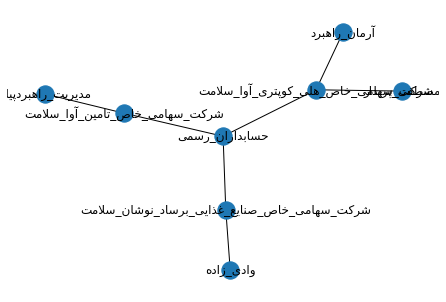

In [ ]:
print(x)
print(g1)

2547
Graph with 15438 nodes and 24184 edges


In [ ]:
[n for n in g1.neighbors(0)]

[10356]